# **CML1 Project 1: Linear Models**
*Student: Mathias Schindler*

*Date of Submission: Nov 7, 2021*

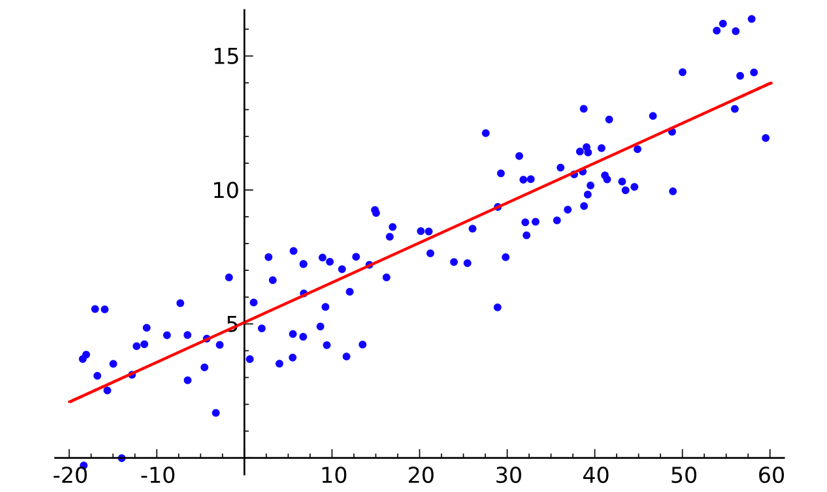

# *Preamble*

In [444]:
#Preamble
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
import sklearn

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/CML1_Projects/Project1_LinearModels/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Inspection & Preparation**

In [445]:
#Load data
train_raw = pd.read_csv("Regression_Supervised_Train.csv", index_col = "lotid")
test_raw = pd.read_csv("Regression_Supervised_Test_updated.csv", index_col = "lotid")
print(train_raw.head(10))
print(test_raw.head(10))

          logerror transactiondate  ...  taxdelinquencyyear  mypointer
lotid                               ...                               
17214744       NaN             NaN  ...                 NaN      25711
12018724       NaN             NaN  ...                 NaN      13268
11306699       NaN             NaN  ...                11.0       5423
11047729       NaN             NaN  ...                 NaN      26198
17174848       NaN             NaN  ...                 NaN      25187
14305657       NaN             NaN  ...                 NaN       6066
11016338       NaN             NaN  ...                 NaN       4138
13961339       NaN             NaN  ...                 NaN       4706
11671803       NaN             NaN  ...                 NaN       5706
11150386       NaN             NaN  ...                 NaN      13350

[10 rows x 47 columns]
          logerror transactiondate  ...  taxdelinquencyflag  taxdelinquencyyear
lotid                               ...     

I begin with removing the features 'totaltaxvalue', 'buildvalue' or 'landvalue' from the training and test dataset, and also 'mypointer' from the training set as specified in the instructions. \\
Then I remove features with >40% missing data. And rows with missing data.

In [446]:
def make_nan_fig(df, title):
  nan_df = df.isnull().sum()/len(df)*100
  nan_df = nan_df.sort_values(ascending = False)

  nan_df_fig = plt.bar(nan_df.index, nan_df.values)
  plt.xticks(rotation='vertical', fontsize = 12)
  plt.ylabel('% NaN', fontsize = 12)
  plt.hlines(y=40, xmin= 0, xmax = 40, linestyle = 'dashed')
  plt.title('NaN data in ' + title + ' dataset as proportion of total observations')
  fig = plt.gcf()
  fig.set_size_inches(18, 5)
  plt.show()
  return nan_df_fig


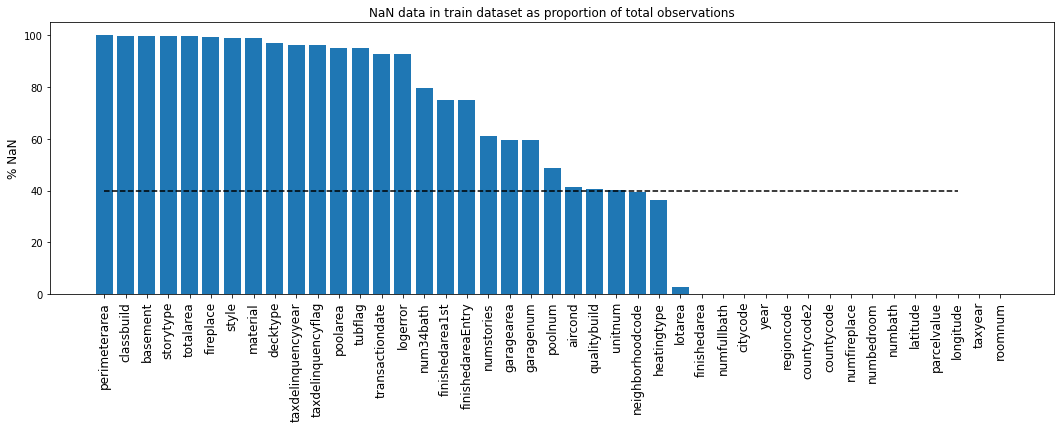

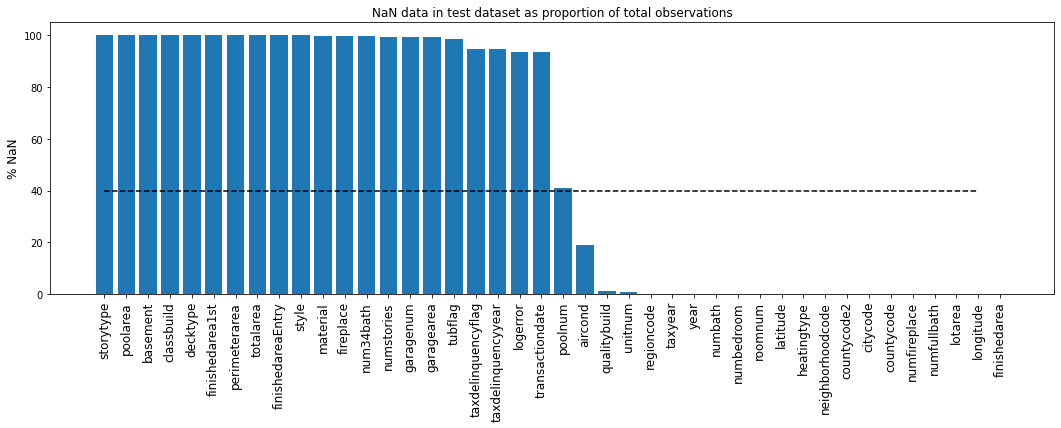

<BarContainer object of 42 artists>

In [447]:
del_feats = ["totaltaxvalue", "buildvalue", "landvalue", "mypointer"]
train_clean = train_raw.drop(del_feats, axis = 1)
test_clean = test_raw.drop(del_feats[0:3], axis = 1)

# Inspect missing data
make_nan_fig(train_clean, "train")
make_nan_fig(test_clean, "test")

So, there is a substantial amount of missing data in both the training and testing dataset. In the training data set we see, that there are 3 variables just over the threshold of 40%. 

In [448]:
# Remove features w. >40% NaN
mypct = 0.6
train_clean = train_clean.dropna(axis = 1, thresh = round(mypct*len(train_clean.index)))
test_clean = test_clean.dropna(axis = 1, thresh = round(mypct*len(test_clean.index)))

# Remove rows w. any NaN
train_clean = train_clean.dropna(axis = 0)
print(test_clean.isnull().sum()) #Features 'aircond', 'qualitybuild', 'unitnum' contain NaN in test

aircond             526
numbath               0
numbedroom            0
qualitybuild         38
finishedarea          0
countycode            0
numfireplace          0
numfullbath           0
heatingtype           0
latitude              0
longitude             0
lotarea               0
citycode              0
countycode2           0
neighborhoodcode      0
regioncode            0
roomnum               0
unitnum              19
year                  0
taxyear               0
dtype: int64


In [449]:
# Check difference in columns
def col_diff(df1, df2):
  df1_col = df1.columns
  df2_col = df2.columns

  print("Columns in " + df1.name + " that are not in " + df2.name + ":")
  print(df1_col.difference(df2_col))
  print("\n")
  print("Columns in " + df2.name + " that are not in " + df1.name + ":")
  print(df2_col.difference(df1_col)) 

train_clean.name, test_clean.name = "train", "test"
col_diff(train_clean, test_clean)

Columns in train that are not in test:
Index(['parcelvalue'], dtype='object')


Columns in test that are not in train:
Index(['aircond', 'qualitybuild', 'unitnum'], dtype='object')


So the training dataset does not contain the variables $aircond$, $qualitybuild$, $unitnum$ that in the testing dataset. Therefore these will be deleted:

In [450]:
del_feats_test = ['aircond', 'qualitybuild', 'unitnum']
test_clean = test_clean.drop(del_feats_test, axis = 1)

print(test_clean.shape)
print(test_clean.columns)

(2746, 17)
Index(['numbath', 'numbedroom', 'finishedarea', 'countycode', 'numfireplace',
       'numfullbath', 'heatingtype', 'latitude', 'longitude', 'lotarea',
       'citycode', 'countycode2', 'neighborhoodcode', 'regioncode', 'roomnum',
       'year', 'taxyear'],
      dtype='object')


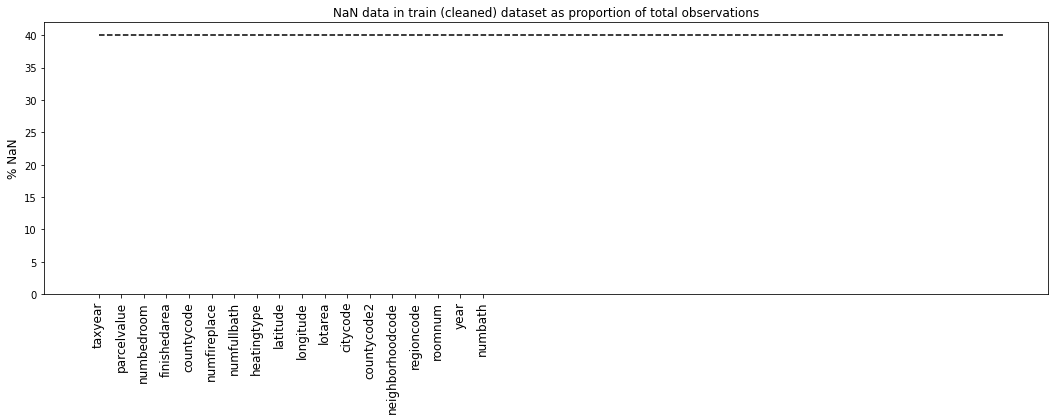

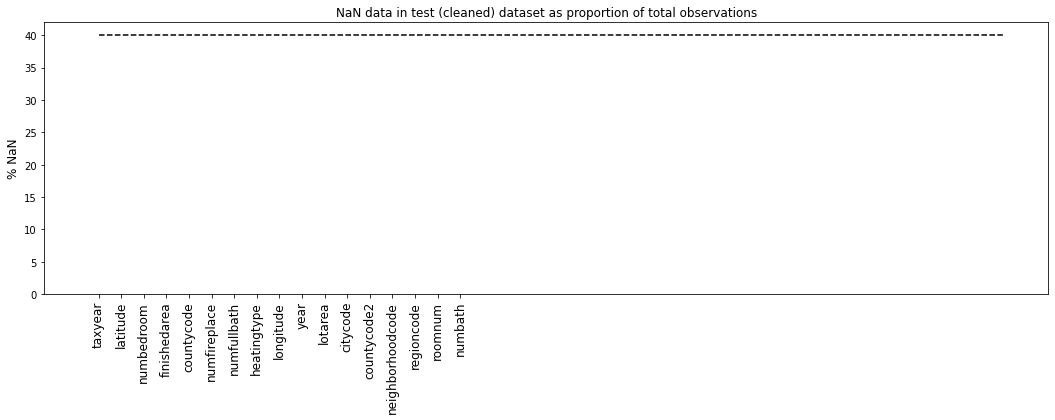

<BarContainer object of 17 artists>

In [451]:
# Inspecting resulting dataframes
make_nan_fig(train_clean, "train (cleaned)")
make_nan_fig(test_clean, "test (cleaned)")
# No missing values in resulting dataframes.

From the $Case\_data\_dictionary.xlsx$-file the following features do not have a natural ordering and are hence considered categorical:


*   $aircond$
*   $style$
*   $classbuild$
*   $countycode$
*   $fireplace$
*   $tubflag$
*   $heatingtype$
*   $countycode2$
*   $citycode$
*   $regioncode$
*   $neighborhoodcode$
*   $storytype$
*   $material$




In [452]:
cat_feat = ['aircond', 'style', 'classbuild', 'countycode', 'fireplace', 'tubflag', 'heatingtype', 'countycode2', 'citycode', 'regioncode', 'neighborhoodcode', 'storytype', 'material']

def is_in_df(vars, df, df_style):
  vars_in_df = []
  for i in vars:
    if i in df.columns:
        print("Yes, " + str(i) + " is in" + df_style)
        vars_in_df.append(i)
    else:
        print("No, " + str(i) + " is not in" + df_style)
  print(vars_in_df)
  return vars_in_df

# I run the function on train and test so make sure they are the same
print("Train:")
cat_feat_train = is_in_df(cat_feat, train_clean, "train")
print("\n Test:")
cat_feat_test = is_in_df(cat_feat, test_clean, "test")

Train:
No, aircond is not intrain
No, style is not intrain
No, classbuild is not intrain
Yes, countycode is intrain
No, fireplace is not intrain
No, tubflag is not intrain
Yes, heatingtype is intrain
Yes, countycode2 is intrain
Yes, citycode is intrain
Yes, regioncode is intrain
Yes, neighborhoodcode is intrain
No, storytype is not intrain
No, material is not intrain
['countycode', 'heatingtype', 'countycode2', 'citycode', 'regioncode', 'neighborhoodcode']

 Test:
No, aircond is not intest
No, style is not intest
No, classbuild is not intest
Yes, countycode is intest
No, fireplace is not intest
No, tubflag is not intest
Yes, heatingtype is intest
Yes, countycode2 is intest
Yes, citycode is intest
Yes, regioncode is intest
Yes, neighborhoodcode is intest
No, storytype is not intest
No, material is not intest
['countycode', 'heatingtype', 'countycode2', 'citycode', 'regioncode', 'neighborhoodcode']


In [453]:
# Inspect the unique values of each categorical feature
for q in ["train_clean", "test_clean"]:
  print(str(q) + "\n" + "-----------------------------------------------------------------------------------")
  if q == "train_clean":
    for i in cat_feat_train:
      print(str(i) + "\n")
      print(train_clean[i].value_counts())
  else:
    for i in cat_feat_test:
      print(str(i) + "\n")
      print(test_clean[i].value_counts())  
  print("\n\n")

# Features "countycode", "countycode2", and "heatingtype" have very little variation
# "Citycode", "regioncode" and "neighborhoodcode" have variation

train_clean
-----------------------------------------------------------------------------------
countycode

6037    12445
6059      115
Name: countycode, dtype: int64
heatingtype

2.0     11621
7.0       830
6.0        99
20.0        9
18.0        1
Name: heatingtype, dtype: int64
countycode2

3101    12445
1286      115
Name: countycode2, dtype: int64
citycode

12447.0     8730
54311.0     1219
46298.0      610
45457.0      556
47019.0      457
54722.0      179
9840.0       133
30908.0       92
54299.0       88
39308.0       79
26964.0       71
16764.0       70
51617.0       52
51861.0       48
37688.0       44
396054.0      38
47568.0       22
52650.0       22
48424.0       16
12520.0       11
42150.0       11
33612.0       11
53571.0        1
Name: citycode, dtype: int64
regioncode

96389.0    414
96364.0    335
96379.0    322
96356.0    320
96339.0    298
          ... 
96212.0      1
96217.0      1
96234.0      1
96957.0      1
96954.0      1
Name: regioncode, Length: 196, dtype: 

Now I create dummies for the categorical features. Although $regioncode$ and $neighborhoodcode$ are categorical features there are too many instances where the unique codes are different in the training and testing dataset, respectively. Hence, they will not be transformed with dummies.

In [454]:
# Creating dummies for categorical variables:
train_clean = pd.get_dummies(train_clean, prefix=['county_'], columns=['countycode'], drop_first = True)
train_clean = pd.get_dummies(train_clean, prefix=['county2_'], columns=['countycode2'], drop_first = True)
train_clean = pd.get_dummies(train_clean, prefix=['heat_'], columns=['heatingtype'], drop_first = True)
train_clean = pd.get_dummies(train_clean, prefix=['city_'], columns=['citycode'], drop_first = True)
#train_clean = pd.get_dummies(train_clean, prefix=['region_'], columns=['regioncode'], drop_first = True)
#train_clean = pd.get_dummies(train_clean, prefix=['nbhd_'], columns=['neighborhoodcode'], drop_first = True)

test_clean = pd.get_dummies(test_clean, prefix=['county_'], columns=['countycode'], drop_first = True)
test_clean = pd.get_dummies(test_clean, prefix=['county2_'], columns=['countycode2'], drop_first = True)
test_clean = pd.get_dummies(test_clean, prefix=['heat_'], columns=['heatingtype'], drop_first = True)
test_clean = pd.get_dummies(test_clean, prefix=['city_'], columns=['citycode'], drop_first = True)
#test_clean = pd.get_dummies(test_clean, prefix=['region_'], columns=['regioncode'], drop_first = True)
#test_clean = pd.get_dummies(test_clean, prefix=['nbhd_'], columns=['neighborhoodcode'], drop_first = True)

In [455]:
# Check difference in columns
train_clean.name, test_clean.name = "train", "test"
col_diff(train_clean, test_clean)

#Value counts of the differences in features:
print("\n\n")
print(train_clean["city__53571.0"].value_counts())  # 1 instance of =1
print(train_clean["heat__18.0"].value_counts())     # 1 instance of =1

Columns in train that are not in test:
Index(['city__53571.0', 'heat__18.0', 'parcelvalue'], dtype='object')


Columns in test that are not in train:
Index([], dtype='object')



0    12559
1        1
Name: city__53571.0, dtype: int64
0    12559
1        1
Name: heat__18.0, dtype: int64


Deleting $citycode=53571$ and $heatingtype=18$ only reduces the training dataset with two observations while making sure that the columns are the same across the training and testing dataset. These two observations should not change the results that much. In this case, I therefore determine that the benefits outweight the costs of removing these two columns from the training dataset:

In [456]:
train_clean = train_clean.drop("city__53571.0", axis = 1)
train_clean = train_clean.drop("heat__18.0", axis = 1)

In [457]:
#Final check of comparison
train_clean.name, test_clean.name = "train", "test"
col_diff(train_clean, test_clean)

Columns in train that are not in test:
Index(['parcelvalue'], dtype='object')


Columns in test that are not in train:
Index([], dtype='object')


Now I split the data into the dependent variable $parcelvalue$ and predictors:

In [458]:
y = train_clean["parcelvalue"]
x = train_clean.drop("parcelvalue", axis=1)

# **Baseline OLS Predictions**

First, I create a baseline OLS regression:

In [459]:
#from sklearn.linear_model import LinearRegression

# Instantiate model
regr = LinearRegression()

# Fit model
coef_OLS = regr.fit(x,y).coef_

# Display parameter estimates
list(map('{:.7f}'.format,coef_OLS))

['-16684.6867281',
 '-122534.3034178',
 '455.6589802',
 '-37640.9267400',
 '85953.6630229',
 '-0.2832141',
 '-0.3622186',
 '0.0340672',
 '-0.2786721',
 '-1043.5317417',
 '-57962.8336918',
 '-908.8762866',
 '18934.2224757',
 '780531.7165531',
 '-780531.7165531',
 '93746.8498604',
 '53571.5028428',
 '52234.9252404',
 '38044.0484958',
 '432307.2298662',
 '-280771.4566719',
 '597896.4935050',
 '473135.7057454',
 '167585.5003341',
 '239410.1060335',
 '528952.6764883',
 '-97355.6722715',
 '164334.7696057',
 '47068.1390256',
 '233066.0122778',
 '-333894.3003239',
 '177901.4095044',
 '-75369.2701557',
 '460265.1461681',
 '-433151.0250948',
 '452765.6565075',
 '95885.4288700',
 '-74377.8884952',
 '281317.1735470']

In [460]:
# Produce predictions using test dataset
y_hat_test = regr.predict(test_clean)
y_hat_test

array([715576.42471263, 722979.77359857, 116713.3079537 , ...,
       719483.93805668, 309938.89345671, 373912.52300406])

# **Exporting Predictions for Kaggle-Submission**

In [465]:
# .csv for Kaggle-submission
submission = pd.DataFrame({"lotid": test_clean.index, "parcelvalue": y_hat_test})
print(submission.shape)
submission.to_csv("/content/drive/My Drive/CML1_Projects/Project1_LinearModels/Predictions/pred10_cat_vars_no-lotid.csv", index = False)

(2746, 2)
